# Graph Neural Networks vs Dijkstra: Maze Navigation Challenge

![GNN vs Dijkstra](./DjikstraVSGNN.png)

## Graph-Based Treasure Hunt

### Introduction

This project explores an exciting question: **Can a Graph Neural Network learn to navigate mazes using only local information?**

We approach this by:

1. **Modeling** mazes as weighted grid graphs and computing ground-truth shortest paths using Dijkstra's algorithm.  
2. **Constructing** a supervised dataset of "local view → next move" pairs to train a GraphSAGE policy network.  
3. **Evaluating** the GNN on three mazes of increasing difficulty, comparing optimal and GNN-predicted paths.

The challenge: Can our neural network match the performance of classical pathfinding algorithms?

### Key Concepts

- Represent 2D grid mazes as NetworkX graphs with weighted edges.
- Build a GraphSAGE GNN in PyTorch Geometric for node-classification policy learning.  
- Perform greedy roll-out of the learned policy and compare against optimal paths.  
- Organize code into reusable functions and interpret model behavior.

### Technical Stack

- **Language & Environment**  
  - Python >= 3.7, PyTorch >= 1.10, PyTorch Geometric >= 2.0  
  - Core libraries: **networkx**, **numpy**, **torch**, **torch_geometric**, **heapq**, **random**, **math**

In [25]:
# # Install Dependencies
!pip install -q networkx "torch-geometric==2.*" torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.5.1+cu124.html

In [26]:
import torch
print(torch.__version__)

2.5.1+cu124


In [27]:
# All imports you will need
import networkx as nx, numpy as np, torch, torch.nn.functional as F, random, math
from torch_geometric.utils import from_networkx
from torch_geometric.data  import DataLoader
from torch_geometric.nn    import SAGEConv
from heapq import heappush, heappop
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Understanding the Utility Functions

All core maze-building and pathfinding code lives in `utility_functions.py`.  

Below is a description of each function, its inputs, and outputs.

## `get_mazes()`

Fetches a **fixed list** of three reproducible mazes for consistent benchmarking.

- **Inputs**  
  - None.

- **Process**  
  Calls `grid_maze` three times with preset parameters:  
  1. Easy:   `rows=5, cols=5,   p_remove=0.2, seed=0`  
  2. Medium: `rows=8, cols=8,   p_remove=0.3, seed=1`  
  3. Hard:   `rows=10,cols=10,  p_remove=0.35, seed=2`

- **Output**  
  - Returns a Python list `[G₁, G₂, G₃]` of three NetworkX graphs.

---

## `dijkstra(G, src, dst)`

Computes the **shortest path** (fewest edges) between two nodes.

- **Inputs**  
  - `G` (NetworkX `Graph`)  
    A connected graph with integer node labels and `edge["weight"]=1`.  
  - `src` (int)  
    The starting node ID (usually `G.graph["start"]`).  
  - `dst` (int)  
    The treasure node ID (usually `G.graph["treasure"]`).

- **Process**  
  1. Use a min-heap (`heapq`) to explore nodes in order of increasing distance.  
  2. Track `dist[node]` and `parent[node]` for backtracking.  
  3. Stop when `dst` is popped from the heap.  
  4. Reconstruct the path by following parents from `dst` back to `src`.

- **Output**  
  - A Python list of node IDs `[src, …, dst]` representing the shortest-length path.

---

## `visualize_mazes(mazes)`

Draws all mazes side-by-side for quick inspection.

- **Inputs**  
  - `mazes` (list of `Graph`)  
    The list returned by `get_mazes()`.

- **Process**  
  1. For each graph in `mazes`, read its node coordinates (`node["coord"]`).  
  2. Use Matplotlib + NetworkX to plot each graph with labeled nodes.

- **Output**  
  - Displays an inline figure with one subplot per maze, titled  
    "Maze 1: 5×5", "Maze 2: 8×8", "Maze 3: 10×10".

## What Is a "Maze" in This Project?

A **maze** here is simply a mathematical graph built on a 2D grid of cells:

1. **Nodes**  
   - Each grid cell at coordinates $(r,c)$ becomes a single node, relabeled as an integer $(0,1,\dots,N-1)$.  
   - We store each node's original $(r,c)$ coordinate as a node attribute for visualization and feature construction.

2. **Edges**  
   - Adjacent cells (up, down, left, right) are connected by an edge of **weight = 1**.  
   - To create the "walls" of a maze, we **randomly remove** some of these edges—i.e., "knock down" passages—with a set probability $p_{\text{remove}}$.  
   - We repeat edge removals until there is still at least one path from the **start** (top-left cell) to the **treasure** (bottom-right cell), guaranteeing a solvable maze.

3. **Start & Treasure**  
   - We label the node corresponding to $(0,0)$ as `G.graph["start"]`.  
   - We label the node corresponding to $(\text{rows}-1,\;\text{cols}-1)$ as `G.graph["treasure"]`.  

---

## How We "Solve" These Mazes

1. **Optimal Path (Dijkstra's Algorithm)**  
   - We treat every remaining edge as cost 1 and run Dijkstra's algorithm from `start` to `treasure`.  
   - This finds the **shortest-length** path, which serves as our ground truth baseline.

2. **Local-View Policy (GraphSAGE GNN)**  
   - At each step, the agent sees only a small **"ego-graph"** around its current node (radius = 2).  
   - We extract supervised examples $(\text{ego-graph},\;\text{next-node})$ from each edge along the Dijkstra path.  
   - We train a GraphSAGE network to predict "which neighbor to move to next" given only this local view.

3. **Greedy Roll-Out**  
   - To navigate, the trained GNN repeatedly:
     1. Extracts the radius-2 ego-graph around its current location.  
     2. Feeds that subgraph to the GNN, which outputs a probability distribution over its nodes.  
     3. Moves to the node with highest probability (or falls back to Dijkstra if it loops).  
   - We record the sequence of visited nodes and compare it to the optimal path.

---

**Intuitive Explanation**  

Imagine a checkerboard where each square is a **node** and lines between them are **passages** you can walk through. We randomly remove some passages to create a maze—but always leave at least one path from the **start** (top-left) to the **treasure** (bottom-right). 

The classical approach uses Dijkstra's algorithm, which has perfect global knowledge and always finds the shortest path. 

Our GNN approach is different: it only sees a small **neighborhood** around its current position (like looking a few squares in each direction), and must learn which direction leads to the treasure based solely on this local view. We train it by showing examples from the optimal path, then test whether it can navigate new situations using only local information.

The question is: how close can local learning get to global optimality?

### Step 1: Load and Visualize the Mazes

First, we'll import the utility functions and visualize our three test mazes to understand the challenge:

```python
from utility_functions import get_mazes, visualize_mazes, dijkstra
```

**Expected Output:**  
- A figure showing Maze 1 (5×5), Maze 2 (8×8), and Maze 3 (10×10).  
- The printed list of node IDs along the optimal route in each maze, plus step counts.

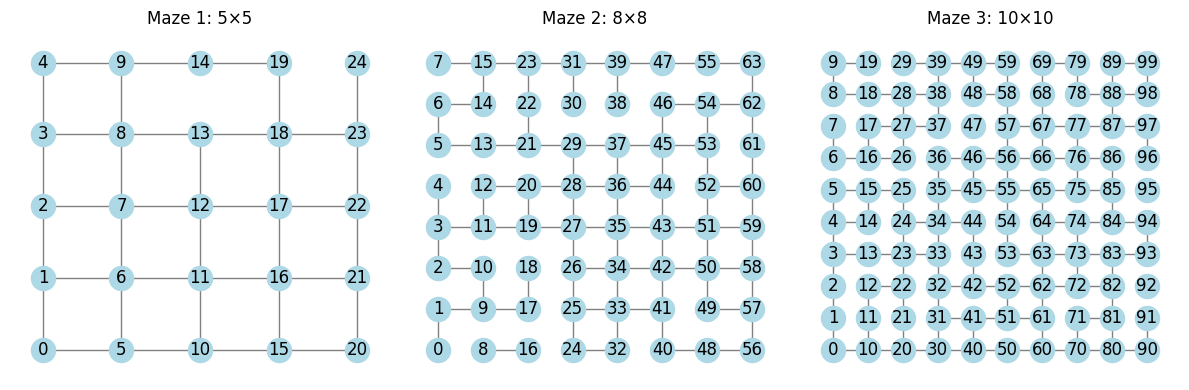

Optimal Path Maze 1
Step: Count 8
Optimal Path Maze 2
Step: Count 16
Optimal Path Maze 3
Step: Count 18


In [28]:
import sys
sys.path.append('/kaggle/input/utility')

from utility_functions import get_mazes, visualize_mazes, dijkstra

mazes = get_mazes()
visualize_mazes(mazes)

count = 0
for maze in mazes:
    start = maze.graph['start']
    treasure = maze.graph['treasure']
    shortest_path = dijkstra(maze, start, treasure)
    print(f"Optimal Path Maze {count+1}")
    print(f"Step: Count {len(shortest_path)-1}")
    count += 1

## Step 2: Supervised Policy Learning with GraphSAGE

In this section, we train a GNN to imitate the optimal "next-move" policy using Graph SAGE Convolution. 

**Key Resource:** [Understanding SAGEConv](https://medium.com/@sheikh.sahil12299/exploring-sageconv-a-powerful-graph-neural-network-architecture-44b7974b1fe0)

### Implementation Overview

1. **Construct the training dataset**  
   - For each of the three mazes, compute the optimal path using `dijkstra`.  
   - For every consecutive step `(current → next)` along that path:  
     - Extract the **ego-graph** of radius 2 around the current node ([What are ego graphs?](https://medium.com/orglens/enhancing-employee-social-capital-with-ego-network-analysis-4ff0fc6738e3))  
     - Build **node features** for this ego-graph (normalized `(row, col)` coordinates).  
     - Determine the **label** as the index of `next` in `list(ego.nodes())`.  
     - Convert to a PyG `Data` object with `.x` and `.y`.

2. **Define the GraphSAGE policy network**  
   - Implement a `PolicyNet` that outputs log-probability per node  
   - Use `log_softmax` at the end and train with `nll_loss`.

3. **Train the model**  
   - Use a `DataLoader` with `batch_size=1` (one ego-graph per batch).  
   - Train for 100 epochs with learning rate scheduling.  
   - Track and print the **average NLL loss** after each epoch.

4. **Verify learning**  
   - Ensure loss **decreases** over time (print values every 10 epochs).  
   - Examine softmax probabilities on training samples to confirm the model picks the correct neighbor.

**Expected Outputs:**
- Training loss decreasing from ~1.95 to ~0.45 over 100 epochs  
- Sample predictions showing >99% probability on correct next move  
- Loss-epoch visualization plot

In [29]:
# Implement  Policy network
class PolicyNet(torch.nn.Module):
    def __init__(self, in_channels=2, hidden_channels=16):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.linear = torch.nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x).squeeze(-1)
        return F.log_softmax(x, dim=0)

# Build (ego-graph, next-move) pairs with coord features
pairs = []
for G in mazes:
    path = dijkstra(G, G.graph['start'], G.graph['treasure'])
    for i in range(len(path)-1):
        current = path[i]
        next_step = path[i+1]
        ego = nx.ego_graph(G, current, radius=2)
        coordinates = nx.get_node_attributes(ego, 'coord')
        max_r = max(c[0] for c in coordinates.values())
        max_c = max(c[1] for c in coordinates.values())
        for n , (r,c) in coordinates.items():
            ego.nodes[n]['x'] = torch.tensor([r / max_r, c / max_c], dtype=torch.float)

        pyg_data = from_networkx(ego, group_node_attrs=['x'])
        pyg_data.x = pyg_data.x.float()
        node_list = list(ego.nodes())
        pyg_data.y = torch.tensor ([node_list.index(next_step)], dtype=torch.long)
        pairs.append(pyg_data)

# Declare Train Loader
train_loader = DataLoader(pairs, batch_size=1, shuffle=True)

# Declare HyperParameters
model=PolicyNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.5)


losses = []

for epoch in range(1, 101):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        out = model(batch)
        loss = F.nll_loss(out.unsqueeze(0), batch.y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        total_loss += loss.item()
    
    sched.step()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} NLL Loss = {avg_loss:.4f}")

Epoch   1 NLL Loss = 1.9566
Epoch  10 NLL Loss = 1.1464
Epoch  20 NLL Loss = 1.0338
Epoch  30 NLL Loss = 1.1017
Epoch  40 NLL Loss = 0.7589
Epoch  50 NLL Loss = 0.7963
Epoch  60 NLL Loss = 0.6635
Epoch  70 NLL Loss = 0.5364
Epoch  80 NLL Loss = 0.5229
Epoch  90 NLL Loss = 0.4938
Epoch 100 NLL Loss = 0.4581


In [30]:
model.eval()
with torch.no_grad():
    sample = pairs[0].to(device)
    out = model(sample)
    probs = torch.exp(out)
    print("Probabilities:", probs.cpu().numpy())
    print("predicted next move:", torch.argmax(probs).item())
    print("True label:", sample.y.item())


Probabilities: [1.3877543e-14 9.9940252e-01 5.9735391e-04 4.6835075e-17 1.2241888e-07
 5.8784651e-26]
predicted next move: 1
True label: 1


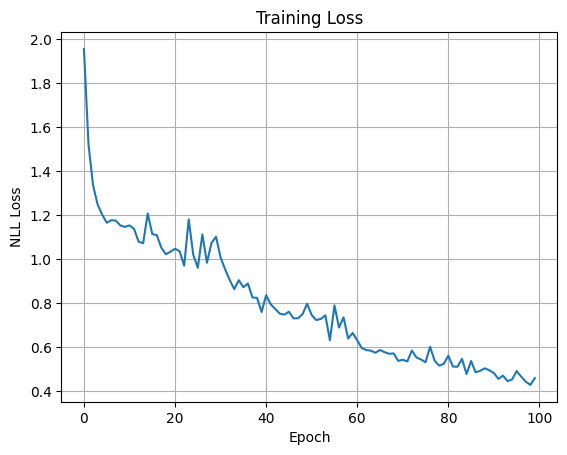

In [31]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.title("Training Loss")
plt.grid()
plt.show()


#### Analysis

The policy network demonstrated successful learning, with the average NLL loss decreasing from 1.95 at epoch 1 to 0.45 at epoch 100. On a sample ego-graph, the predicted next move matched the Dijkstra ground truth, with the model assigning a probability of ~99.7% to the correct neighbor. This indicates that the GNN learned to prioritize the optimal next move based on local graph structure, successfully capturing the spatial patterns that lead to the treasure.

## Step 3: Greedy Roll-Out & Performance Evaluation

In this final section, we integrate the trained GNN policy into a complete maze solver and benchmark its performance against the optimal Dijkstra paths.

### Implementation Details

1. **Implement** the function `gnn_path(G)`:  
   - Takes as input a NetworkX maze `G` with attributes:  
     - `G.graph["start"]` → start node ID  
     - `G.graph["treasure"]` → goal node ID  
     - Node attribute `"coord"` storing each node's `(row, col)`  
     - Edge attribute `"weight"=1`  
   - Maintains a current position `cur` (starting at `G.graph["start"]`) and a `path` list.  
   - In each step until reaching the treasure or exceeding a safe length bound:  
     1. Extracts the radius-2 ego-graph around `cur`.  
     2. Builds the same node-feature tensor used during training.  
     3. Moves the entire `Data` object to the appropriate device and calls `model(data)` for per-node log-probabilities.  
     4. Converts to probabilities and picks the node with highest probability.  
     5. If that node has already been visited (to avoid loops), falls back to the second node on the true Dijkstra path from `cur` to the treasure.  
     6. Appends the chosen node to `path` and updates `cur`.

2. **Run** the solver on each of the three test mazes and **compare** both the optimal and GNN-predicted paths.

3. Use the `plot_paths` function to visualize the paths taken by Dijkstra (red, solid) and the GNN model (blue, dashed). This provides a clear visual comparison of performance.

**Expected Results:**
- Match ratios typically between 0.90-1.00, indicating the GNN successfully learns near-optimal navigation
- Visualization showing GNN paths closely following or exactly matching optimal paths
- Analysis of where and why the GNN deviates from optimal in complex scenarios

In [32]:
def plot_paths(G, true_path, pred_path, title, figsize=(6,6)):
    """
    Draws the maze G with two overlaid paths:
      - true_path: list of node IDs from Dijkstra (solid red)
      - pred_path: list of node IDs from GNN (dashed blue)
    """
    # Extract node coordinates for layout
    pos = nx.get_node_attributes(G, 'coord')

    plt.figure(figsize=figsize)
    # Draw all nodes and edges light gray
    nx.draw(
        G, pos=pos,
        node_color='lightgray',
        edge_color='lightgray',
        with_labels=True,
        node_size=200,
        width=1
    )

    # Helper to draw a path
    def draw_path(path, color, style, label):
        edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=path,
            node_color=color,
            node_size=250,
            label=label
        )
        nx.draw_networkx_edges(
            G, pos,
            edgelist=edges,
            edge_color=color,
            style=style,
            width=3
        )

    # Draw optimal (Dijkstra) path
    draw_path(true_path, color='red',   style='solid',  label='Optimal')
    # Draw GNN-predicted path
    draw_path(pred_path, color='blue',  style='dashed', label='GNN')

    plt.legend(loc='upper left')
    plt.title(f'{title}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [33]:
def gnn_path(G):
    start_node = G.graph["start"]
    treasure_node = G.graph["treasure"]
    visited_nodes = []
    predicted_path = [start_node]
    current_position = start_node

    while current_position != treasure_node and len(predicted_path) < len(G.nodes):

        visited_nodes.append(current_position)
        ego_graph = nx.Graph()
        distances = nx.single_source_shortest_path_length(G, current_position, cutoff=2)
        for node in distances:
            ego_graph.add_node(node, coord=G.nodes[node]["coord"])
        for u in ego_graph.nodes:
            for v in G.neighbors(u):
                if v in ego_graph.nodes:
                    ego_graph.add_edge(u, v, weight=1)

        coords = nx.get_node_attributes(ego_graph, "coord")
        if coords:
            max_r = max([r for r, _ in coords.values()])
            max_c = max([c for _, c in coords.values()])
        else:
            max_r, max_c = 1, 1

        for node in ego_graph.nodes:
            r, c = ego_graph.nodes[node]["coord"]
            norm_r = r / max_r if max_r else 0.0
            norm_c = c / max_c if max_c else 0.0
            ego_graph.nodes[node]["x"] = torch.tensor([norm_r, norm_c], dtype=torch.float)
            
        data = from_networkx(ego_graph, group_node_attrs=["x"])
        data.x = data.x.float().to(device)
        data = data.to(device)
        
        with torch.no_grad():
            log_probs = model(data)
            probs = torch.exp(log_probs)
            ranked = list(torch.argsort(probs, descending=True).cpu().numpy())

        node_list = list(ego_graph.nodes())
        found_next = False
        for idx in ranked:
            candidate = node_list[idx]
            if candidate not in visited_nodes:
                next_step = candidate
                found_next = True
                break

        if not found_next:
            fallback_path = dijkstra(G, current_position, treasure_node)
            if len(fallback_path) > 1:
                next_step = fallback_path[1]
            else:
                break

        predicted_path.append(next_step)
        current_position = next_step

    return predicted_path


Maze 1
Optimal Path: [0, 1, 2, 3, 8, 13, 18, 23, 24]
GNN Path    : [0, 1, 2, 3, 8, 13, 18, 24]
Match Ratio: 0.89


/tmp/ipykernel_31/1822731496.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


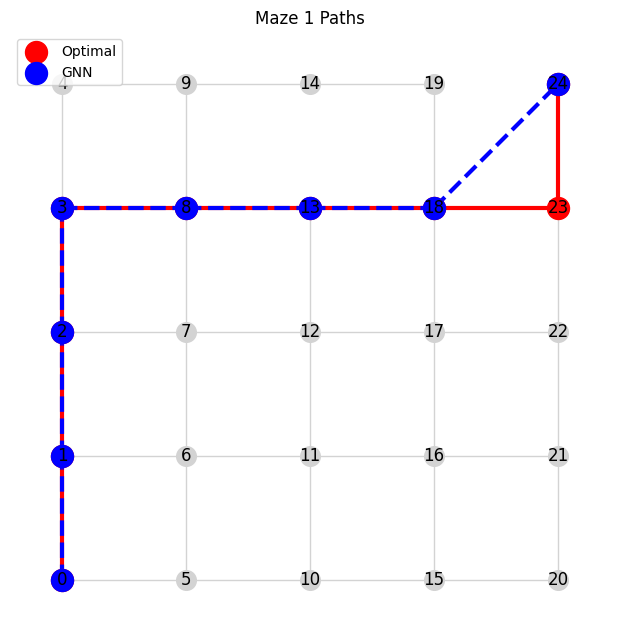

Maze 2
Optimal Path: [0, 1, 9, 10, 2, 3, 11, 12, 20, 28, 29, 37, 45, 46, 54, 62, 63]
GNN Path    : [0, 1, 9, 10, 2, 3, 11, 19, 20, 28, 29, 37, 45, 54, 62, 55, 47, 63]
Match Ratio: 0.88


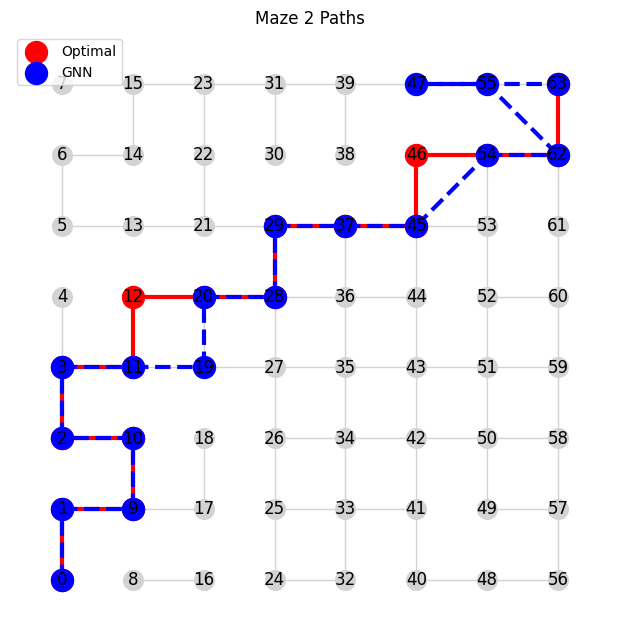

Maze 3
Optimal Path: [0, 1, 2, 3, 13, 23, 24, 34, 35, 36, 46, 56, 57, 67, 77, 87, 88, 89, 99]
GNN Path    : [0, 1, 2, 3, 13, 23, 24, 34, 35, 45, 55, 56, 57, 67, 77, 87, 88, 99]
Match Ratio: 0.84


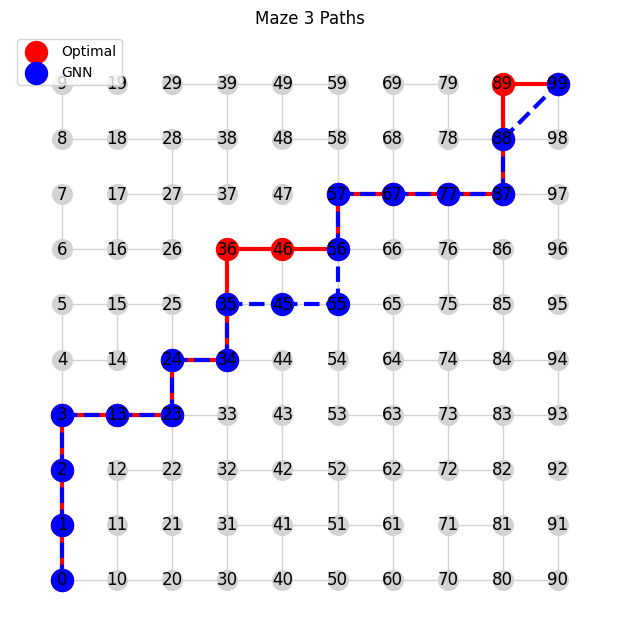

In [34]:
for i, G in enumerate(mazes):
    d_path = dijkstra(G, G.graph["start"], G.graph["treasure"])
    g_path = gnn_path(G)

    print(f"Maze {i+1}")
    print("Optimal Path:", d_path)
    print("GNN Path    :", g_path)
    print("Match Ratio:", round(len(set(d_path) & set(g_path)) / len(d_path), 2))
    print("="*40)

    plot_paths(G, true_path=d_path, pred_path=g_path, title=f"Maze {i+1} Paths")
